<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/16-natural-nanguage-processing-with-RNNs-and-Attention/4_attention_mechanisms_transformer_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Mechanisms: The Transformer Architecture

Consider the path from the word **“milk”** to its translation **“lait”** below. it is quite long! 

This means that a representation of this word (along with all the other words) needs to be carried over many steps before it is actually used. Can’t we make this path shorter?

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/simple-machine-translation-model.png?raw=1' width='800'/>

This was the core idea in a groundbreaking [2014 paper](https://arxiv.org/abs/1409.0473) by Dzmitry Bahdanau et al. They introduced a technique that allowed the decoder to focus on the appropriate words (as encoded by the encoder) at each time step.

For example, at the time step where the decoder needs to output the word **“lait,”** it will focus its attention on the word **“milk.”**

This means that the path from an input word to its translation is now much shorter, so the short-term memory limitations of RNNs have much less impact.

Attention mechanisms revolutionized neural machine translation and NLP in general), allowing a significant improvement in the state of the art, especially for long sentences (over 30 words).

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/encoder–decoder-attention-model.png?raw=1' width='800'/>

Instead of just sending the encoder’s final hidden state to the decoder (which is still done, although it is not shown in the figure), we now send all of its outputs to the decoder. 

At each time step, the decoder’s memory cell computes a weighted sum of all these encoder outputs: this determines which words it will focus on at this step. The weight $α(t,i)$ is the weight of the ith encoder output at the tth decoder time step.

For example, if the weight $α(3,2)$ is much larger than the weights $α(3,0)$ and $α(3,1)$, then the decoder will pay much more attention to word number 2 (**“milk”**) than to the other two words, at least at this time step. 

The rest of the decoder works just like earlier: at each time step the memory cell receives the inputs we just discussed, plus the hidden state from the previous time step, and finally (although it is not represented in the diagram) it receives the target word from the previous time step (or at inference time, the output from the previous time step).

But where do these $α(t,i)$ weights come from? It’s actually pretty simple: they are generated by a type of small neural network called an alignment model (or an attention layer), which is trained jointly with the rest of the Encoder–Decoder model. This alignment model is illustrated on the righ-hand side.

This layer outputs a score (or energy) for each encoder output (e.g., $e(3, 2)$): this score measures how well each output is aligned with the decoder’s previous hidden state.

Finally, all the scores go through a softmax layer to get a final weight for each encoder output (e.g., $α(3,2)$). All the weights for a given decoder time step add up to 1 (since the
softmax layer is not time-distributed). 

This particular attention mechanism is called Bahdanau attention.
Since it concatenates the encoder output with the decoder’s previous hidden state, it is sometimes called concatenative attention (or additive attention).

## Setup

In [ ]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
  IS_COLAB = True
except Exception:
  IS_COLAB = False
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

TensorFlow 2.x selected.


## Visual Attention

Attention mechanisms are now used for a variety of purposes. One of their first applications beyond NMT was in generating image captions using [visual attention](https://arxiv.org/abs/1502.03044).

A convolutional neural network first processes the image and outputs some feature maps, then a decoder RNN equipped with an attention mechanism generates the caption, one word at a time. At each decoder time step (each word), the decoder uses the
attention model to focus on just the right part of the image.

For example, the model generated the caption “A woman is throwing a frisbee in a park,” and you can see what part of the input image the decoder focused its attention on when it was about to output the word “frisbee”: clearly, most of its attention was focused on the frisbee.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/visual-attention.png?raw=1' width='800'/>

Attention mechanisms are so powerful that you can actually build state-of-the-art models using only attention mechanisms.

## Attention Is All You Need: The Transformer Architecture

In a [ground-breaking 2017 paper](https://arxiv.org/abs/1706.03762),20 a team of Google researchers suggested that
“Attention Is All You Need.” 

They managed to create an architecture called the Transformer,
which significantly improved the state of the art in NMT without using any recurrent or convolutional layers,21 just attention mechanisms (plus embedding layers, dense layers, normalization layers, and a few other bits and pieces). 

As an extra bonus, this architecture was also much faster to train and easier to parallelize, so they managed to train it at a fraction of the time and cost of the previous state-of-the-art
models.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/transformer-architecture.png?raw=1' width='800'/>

Let’s walk through this figure:
* The lefthand part is the encoder. Just like earlier, it takes as input a batch of sentences represented as sequences of word IDs (the input shape is [batch size, max input sentence length]), and it encodes each word into a 512-dimensional representation
(so the encoder’s output shape is [batch size, max input sentence length, 512]). Note that the top part of the encoder is stacked N times.
* The righthand part is the decoder. During training, it takes the target sentence as input (also represented as a sequence of word IDs), shifted one time step to the right (i.e., a start-of-sequence token is inserted at the beginning). It also receives the outputs of the encoder (i.e., the arrows coming from the left side).
* During inference, the decoder cannot be fed targets, so we feed it the previously output words (starting with a start-of-sequence token). So the model needs to be called repeatedly, predicting one more word at every round (which is fed to the decoder at the next round, until the end-of-sequence token is output).
* Looking more closely, you can see that you are already familiar with most components: there are two embedding layers, 5 × N skip connections, each of them followed by a layer normalization layer, 2 × N “Feed Forward” modules that are
composed of two dense layers each (the first one using the ReLU activation function, the second with no activation function), and finally the output layer is a dense layer using the softmax activation function. All of these layers are timedistributed,
so each word is treated independently of all the others. But how can we translate a sentence by only looking at one word at a time? Well, that’s where the new components come in:
  * —The encoder’s Multi-Head Attention layer encodes each word’s relationship with every other word in the same sentence, paying more attention to the most relevant ones.
  * —The positional embeddings are simply dense vectors (much like word embeddings) that represent the position of a word in the sentence. The nth positional embedding is added to the word embedding of the nth word in each sentence. This gives the model access to each word’s position, which is needed because the Multi-Head Attention layers do not consider the order or the position of the words; they only look at their relationships. Since all the other layers are time-distributed, they have no way of knowing the position of each word(either relative or absolute). Obviously, the relative and absolute word positions
are important, so we need to give this information to the Transformer somehow, and positional embeddings are a good way to do this.


### Positional embeddings

A positional embedding is a dense vector that encodes the position of a word within a sentence: the ith positional embedding is simply added to the word embedding of the ith word in the sentence. These positional embeddings can be learned by the model, but in the paper the authors preferred to use fixed positional embeddings, defined using the sine and cosine functions of different frequencies.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/positional-embeddings-equation.png?raw=1' width='800'/>

The positional embedding matrix P is represented at the bottom of
Figure, where Pp,i is the ith component of the embedding for the
word located at the pth position in the sentence.

There is no PositionalEmbedding layer in TensorFlow, but it is easy to create one. 

For efficiency reasons, we precompute the positional embedding matrix in the constructor (so we need to know the maximum sentence length, max_steps, and the number of dimensions for each word representation, max_dims). 

Then the call() method crops this embedding matrix to the size of the inputs, and it adds it to the inputs. Since we added an extra first dimension of size 1 when creating the positional
embedding matrix, the rules of broadcasting will ensure that the matrix gets added to every sentence in the inputs:



In [ ]:
class PositionalEncoding(keras.layers.Layer):

  def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)

    if max_dims % 2 == 1: # max_dims must be even
      max_dims += 1 
    
    p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
    pos_embedding = np.empty((1, max_steps, max_dims))
    pos_embedding[0, :, ::2] = np.sin(p / 10000 ** (2 * i / max_dims)).T
    pos_embedding[0, :, 1::2] = np.cos(p / 10000 ** (2 * i / max_dims)).T

    self.positional_embedding = tf.constant(pos_embedding.astype(self.dtype))

  def call(self, inputs):
    shape = tf.shape(inputs)
    return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [ ]:
max_steps = 201
max_dims = 512
pos_embedding = PositionalEncoding(max_steps, max_dims)
PE = pos_embedding(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

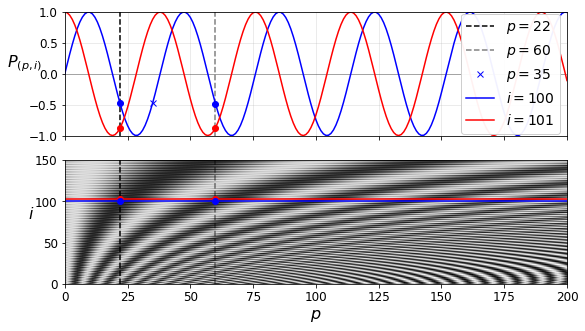

In [ ]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)

ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])

ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")

cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")

ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)

plt.show()

Then we can create the first layers of the Transformer.

In [ ]:
embed_size = 512; max_steps = 500; vocab_size = 10000

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)

encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)

encoder_input = positional_encoding(encoder_embeddings)
decoder_input = positional_encoding(decoder_embeddings)

Now let’s look deeper into the heart of the Transformer model: the **Multi-Head Attention** layer.

### Multi-Head Attention

To understand how a Multi-Head Attention layer works, we must first understand the Scaled Dot-Product Attention layer, which it is based on.

Let’s suppose the encoder analyzed the input sentence “They played chess,” and it managed to understand that the word “They” is the subject and the word “played” is the verb, so it encoded this information in the representations of these words.

Now suppose the decoder has already translated the subject, and it thinks that it should translate the verb next. 

For this, it needs to fetch the verb from the input sentence. This is analog to a dictionary lookup: it’s as if the encoder created a dictionary {“subject”: “They”, “verb”: “played”,
…} and the decoder wanted to look up the value that corresponds to the key “verb.”

However, the model does not have discrete tokens to represent the keys (like “subject” or “verb”); it has vectorized representations of these concepts (which it learned during
training), so the key it will use for the lookup (called the query) will not perfectly match any key in the dictionary.

The solution is to compute a similarity measure between the query and each key in the dictionary, and then use the softmax function to convert these similarity scores to weights that add up to 1. 

If the key that represents the verb is by far the most similar to the query, then that key’s weight will be close to 1. Then the model can compute a weighted sum of the corresponding values, so if the weight of the “verb” key is close to 1, then the weighted sum will be very close to the representation of the word “played.

In short, you can think of this whole process as a differentiable dictionary lookup. The similarity measure used by the Transformer is just the dot product, like in Luong attention. In fact, the equation is the same as for Luong attention, except for a scaling factor.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/scaled-dot-product-attention.png?raw=1' width='800'/>

* Q is a matrix containing one row per query. Its shape is [nqueries, dkeys], where nqueries is the number of queries and dkeys is the number of dimensions of each query and each key.
* K is a matrix containing one row per key. Its shape is [nkeys, dkeys], where nkeys is the number of keys and values.
* V is a matrix containing one row per value. Its shape is [nkeys, dvalues], where dvalues is the number of each value.
* The shape of Q K⊺ is [nqueries, nkeys]: it contains one similarity score for each query/key pair. The output of the softmax function has the same shape, but all rows sum up to 1.
* The scaling factor scales down the similarity scores to avoid saturating the softmax function, which would lead to tiny gradients.
* It is possible to mask out some key/value pairs by adding a very large negative value to the corresponding similarity scores, just before computing the softmax. This is useful in the Masked Multi-Head Attention layer.

In the encoder, this equation is applied to every input sentence in the batch, with Q, K, and V all equal to the list of words in the input sentence (so each word in the sentence will be compared to every word in the same sentence, including itself).

Similarly, in the decoder’s masked attention layer, the equation will be applied to every target sentence in the batch, with Q, K, and V all equal to the list of words in the target sentence, but this time using a mask to prevent any word from comparing itself to words located after it (at inference time the decoder will only have access to the words it already output, not to future words, so during training we must mask out future output tokens).

In the upper attention layer of the decoder, the keys K and values V are simply the list of word encodings produced by the encoder, and the queries Q are the list of word encodings produced by the decoder.

The keras.layers.Attention layer implements Scaled Dot-Product Attention, efficiently applying equation to multiple sentences in a batch. Its inputs are just like Q, K, and V, except with an extra batch dimension (the first dimension).

If we ignore the skip connections, the layer normalization layers, the Feed Forward blocks, and the fact that this is Scaled Dot-Product Attention, not exactly Multi-Head Attention, then the rest of the Transformer model can be implemented like this.

In [ ]:
Z = encoder_input

for N in range(6):
  Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_input

for N in range(6):
  Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
  Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation='softmax'))(Z)

The use_scale=True argument creates an additional parameter that lets the layer learn how to properly downscale the similarity scores. This is a bit different from the Transformer model, which always downscales the similarity scores by the same factor
( squred root of dkeys). 

The causal=True argument when creating the second attention layer
ensures that each output token only attends to previous output tokens, not future ones.

Now it’s time to look at the final piece of the puzzle: what is a Multi-Head Attention layer?

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/multi-head-attention-layer.png?raw=1' width='800'/>

As you can see, it is just a bunch of Scaled Dot-Product Attention layers, each preceded by a linear transformation of the values, keys, and queries (i.e., a timedistributed Dense layer with no activation function).

All the outputs are simply concatenated, and they go through a final linear transformation (again, timedistributed).

But why? What is the intuition behind this architecture? Well, consider the word “played” we discussed earlier (in the sentence “They played chess”). The encoder was smart enough to encode the fact that it is a verb.

But the word representation also includes its position in the text, thanks to the positional encodings, and it probably includes many other features that are useful for its translation, such as the fact that it is in the past tense.

n short, the word representation encodes many different
characteristics of the word. If we just used a single Scaled Dot-Product Attention layer, we would only be able to query all of these characteristics in one shot. 

This is why the Multi-Head Attention layer applies multiple different linear transformations of the values, keys, and queries: this allows the model to apply many different projections of the word representation into different subspaces, each focusing on a subset of the word’s characteristics. 

Perhaps one of the linear layers will project the word representation into a subspace where all that remains is the information that the word is a verb, another linear layer will extract just the fact that it is past tense, and so on. Then
the Scaled Dot-Product Attention layers implement the lookup phase, and finally we concatenate all the results and project them back to the original space.

Here's a basic implementation of the MultiHeadAttention layer. One will likely be added to keras.layers in the near future. Note that Conv1D layers with kernel_size=1 (and the default padding="valid" and strides=1) is equivalent to a TimeDistributed(Dense(...)) layer.



In [ ]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
  
  def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
    self.n_heads = n_heads 
    self.causal = causal
    self.use_scale = use_scale
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.dims = batch_input_shape[0][-1]
    self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3  # could be hyperparameters instead

    self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
    self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
    self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)

    self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
    self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)

    super().build(batch_input_shape)

  def _multi_head_linear(self, inputs, linear):
    shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
    projected = K.reshape(linear(inputs), shape)
    perm = K.permute_dimensions(projected, [0, 2, 1, 3])

    return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])

  def call(self, inputs):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    shape = K.shape(q)

    q_proj = self._multi_head_linear(q, self.q_linear)
    v_proj = self._multi_head_linear(v, self.v_linear)
    k_proj = self._multi_head_linear(k, self.k_linear)

    multi_attended = self.attention([q_proj, v_proj, k_proj])

    shape_attended = K.shape(multi_attended)
    reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
    perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
    concat = K.reshape(perm, [shape[0], shape_attended[1], -1])

    return self.out_linear(concat)

In [ ]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attention = MultiHeadAttention(8)
multi_attention([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])